# Titanic Survival Prediction
Author: Ivan Birkmaier

### Fragen:
1. Wie viele aus dem Test-Datensatz haben überhaupt Familie ? Wie ist dass Verhältnis? Lassen sich überhaupt krasse Rückschlüsse ziehen?
2. Wie viele aus dem Test-Datensatz haben kein Alter? Wie viele aus dem Traindatensatz haben kein alter

## Introducing

This notebook implements the prediction of titanic survivors. A training dataset `train.csv` with 918 passengers including survival status is used to learn a prediction function. A test set `test.csv` contains 418 passengers and will be used to predict their survival.

Your results must be reproducible - please **don't overlook the rules for `random_state`** in the body of this notebook to obtain full credit for your .

In [67]:
print("Versions of the imported modules:")
import pandas as pd
print('pandas:', pd.__version__)
import numpy as np
print('numpy:', np.__version__)
import seaborn as sns
print('seaborn:', sns.__version__)
import re
print('Regex:', re.__version__)
import requests
print('Request:', requests.__version__)


##############################################
from pathlib import Path
# print('pathlib:', Path.__version__)
import matplotlib.pyplot as plt
# print('matplotlib:', plt.__version__)


import os

Versions of the imported modules:
pandas: 2.2.1
numpy: 1.26.4
seaborn: 0.13.2
Regex: 2.2.1
Request: 2.31.0


## Data Exploration

List of Attributes source: https://www.kaggle.com/c/titanic/data<br><br>
![alt text](assets/titanic.PNG "Variables")


### Explore the train dataset

Import train dataset:

In [68]:
data_path = Path.cwd()
train_data = pd.read_csv(data_path/'train.csv', index_col=0)
train_data[:10]

,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S
6,0,3,"Moran, Mr. James",NaN,0,0,330877,8.4583,NaN,Q
7,0,1,"McCarthy, Mr. Timothy J",54.0,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",2.0,3,1,349909,21.0750,NaN,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",27.0,0,2,347742,11.1333,NaN,S


Information about data:

In [69]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Ticket    891 non-null    object 
 7   Fare      891 non-null    float64
 8   Cabin     204 non-null    object 
 9   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 76.6+ KB


In [70]:
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Plot survial ratio

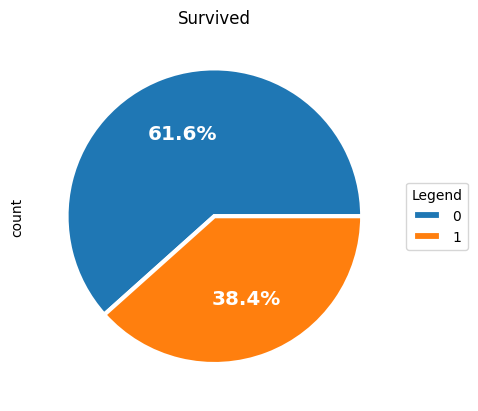

In [71]:
# Your existing code for the pie chart
pie_chart = train_data.Survived.value_counts().plot.pie(autopct='%.1f%%', 
                                                wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'}, 
                                                textprops=dict(size='x-large', color='white', fontweight='bold'))
pie_chart.set_title('Survived')

# Adding the legend
# Assuming the index of your series has the meaningful labels you want to use
labels = train_data.Survived.value_counts().index
plt.legend(labels, title="Legend", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.show()


Survival ratio per Pclass

In [72]:
train_data.groupby(['Pclass']).Survived.agg(Survivor_ratio='mean', Passengers='size')

,Survivor_ratio,Passengers
Pclass,,
1,0.629630,216
2,0.472826,184
3,0.242363,491


Boxplot for Age

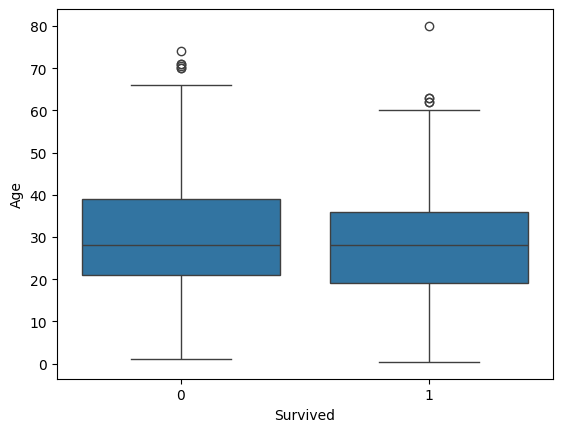

In [73]:
#train_data.set_index('Survived', append=True)['Age'].unstack().boxplot()
sns.boxplot(train_data, x='Survived', y='Age');

# Preprocessing

Laden der Testdaten

In [74]:
test_data = pd.read_csv(data_path/'test.csv', index_col=0)
test_data = test_data.reset_index() #um Id zu behalten als spalte
test_data

,PassengerId,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",NaN,0,0,359309,8.0500,NaN,S


Mergen des Test und Train Datensatzes (Da der Split Familien "trennen" könnte)

In [75]:
train_data = train_data.reset_index() #um Id zu behalten als spalte


# Markiere die Datensätze als 'Train' oder 'Test'
train_data['Dataset'] = 'Train'
test_data['Dataset'] = 'Test'

# Kombiniere beide Datensätze
feature_engineering_df = pd.concat([train_data, test_data], ignore_index=True)

# Ersetze NaN Werte nur in der 'Survived' Spalte mit 2
feature_engineering_df['Survived'].fillna(2, inplace=True)


C:\Users\Ivan\AppData\Local\Temp\ipykernel_162640\2674068342.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  feature_engineering_df['Survived'].fillna(2, inplace=True)


In [136]:
test = train_data[train_data["Age"].isna()]
test

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Dataset
5,6,0,3,"Moran, Mr. James",NaN,0,0,330877,8.4583,NaN,Q,Train
17,18,1,2,"Williams, Mr. Charles Eugene",NaN,0,0,244373,13.0000,NaN,S,Train
19,20,1,3,"Masselmani, Mrs. Fatima",NaN,0,0,2649,7.2250,NaN,C,Train
26,27,0,3,"Emir, Mr. Farred Chehab",NaN,0,0,2631,7.2250,NaN,C,Train
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",NaN,0,0,330959,7.8792,NaN,Q,Train
...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",NaN,0,0,2629,7.2292,NaN,C,Train
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",NaN,8,2,CA. 2343,69.5500,NaN,S,Train
868,869,0,3,"van Melkebeke, Mr. Philemon",NaN,0,0,345777,9.5000,NaN,S,Train
878,879,0,3,"Laleff, Mr. Kristo",NaN,0,0,349217,7.8958,NaN,S,Train


In [135]:
test2 = test_data[test_data["Age"].isna()]
test2

,PassengerId,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Dataset
10,902,3,"Ilieff, Mr. Ylio",NaN,0,0,349220,7.8958,NaN,S,Test
22,914,1,"Flegenheim, Mrs. Alfred (Antoinette)",NaN,0,0,PC 17598,31.6833,NaN,S,Test
29,921,3,"Samaan, Mr. Elias",NaN,2,0,2662,21.6792,NaN,C,Test
33,925,3,"Johnston, Mrs. Andrew G (Elizabeth Lily"" Watson)""",NaN,1,2,W./C. 6607,23.4500,NaN,S,Test
36,928,3,"Roth, Miss. Sarah A",NaN,0,0,342712,8.0500,NaN,S,Test
...,...,...,...,...,...,...,...,...,...,...,...
408,1300,3,"Riordan, Miss. Johanna Hannah""""",NaN,0,0,334915,7.7208,NaN,Q,Test
410,1302,3,"Naughton, Miss. Hannah",NaN,0,0,365237,7.7500,NaN,Q,Test
413,1305,3,"Spector, Mr. Woolf",NaN,0,0,A.5. 3236,8.0500,NaN,S,Test
416,1308,3,"Ware, Mr. Frederick",NaN,0,0,359309,8.0500,NaN,S,Test


In [77]:
feature_engineering_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     1309 non-null   float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Age          1046 non-null   float64
 5   SibSp        1309 non-null   int64  
 6   Parch        1309 non-null   int64  
 7   Ticket       1309 non-null   object 
 8   Fare         1308 non-null   float64
 9   Cabin        295 non-null    object 
 10  Embarked     1307 non-null   object 
 11  Dataset      1309 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


Todo:
- Alter auffüllen
- Fare auffüllen
- Embarked auffüllen
- Cabine analysieren 

# Feature Engineering

### Feature 1: Geschlecht der Passagiere

Es wird versucht über den Namen der Pasagieren (mit Titel/Ansprache z.B Mr.) auf das Geschlecht der Passagiere Rückschlüsse zu ziehen. Grund hierfür ist dass aus rechereche sich ergeben hat das Frauen und Kinder vor den Männern gerettet wurden.

In [78]:
# Funktion, um Namen in ihre Bestandteile zu teilen
def split_name(name):
    parts = re.split(r'[,\. ]+', name)
    surname = parts[0]
    speech = parts[1]
    first_name = " ".join(parts[2:])
    return surname, speech, first_name

# Namen in Bestandteile aufteilen und zu DataFrame hinzufügen
feature_engineering_df[['Surname', 'Speech', 'First_Name']] = feature_engineering_df.apply(lambda x: split_name(x['Name']), axis=1, result_type='expand')

feature_engineering_df.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Dataset,Surname,Speech,First_Name
0,1,0.0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,Train,Braund,Mr,Owen Harris
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,Train,Cumings,Mrs,John Bradley (Florence Briggs Thayer)
2,3,1.0,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Train,Heikkinen,Miss,Laina
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,Train,Futrelle,Mrs,Jacques Heath (Lily May Peel)
4,5,0.0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,Train,Allen,Mr,William Henry


In [79]:
feature_engineering_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     1309 non-null   float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Age          1046 non-null   float64
 5   SibSp        1309 non-null   int64  
 6   Parch        1309 non-null   int64  
 7   Ticket       1309 non-null   object 
 8   Fare         1308 non-null   float64
 9   Cabin        295 non-null    object 
 10  Embarked     1307 non-null   object 
 11  Dataset      1309 non-null   object 
 12  Surname      1309 non-null   object 
 13  Speech       1309 non-null   object 
 14  First_Name   1309 non-null   object 
dtypes: float64(3), int64(4), object(8)
memory usage: 153.5+ KB


In [80]:
unique_speech_values = feature_engineering_df["Speech"].unique()
print(unique_speech_values)

['Mr' 'Mrs' 'Miss' 'Master' 'Planke' 'Don' 'Rev' 'Billiard' 'der' 'Walle'
 'Dr' 'Pelsmaeker' 'Mulder' 'y' 'Steen' 'Carlo' 'Mme' 'Impe' 'Ms' 'Major'
 'Gordon' 'Messemaeker' 'Mlle' 'Col' 'Capt' 'Velde' 'the' 'Shawah'
 'Jonkheer' 'Melkebeke' 'Cruyssen' 'Khalil' 'Palmquist' 'Brito']


**Typische Titel**:
  - **'Mr'**: Ein allgemeiner Titel für einen erwachsenen Mann.
  - **'Mrs'**: Ein Titel für eine verheiratete Frau.
  - **'Miss'**: Ein Titel für eine unverheiratete Frau.
  - **'Master'**: Ein traditioneller Titel für einen jungen Mann oder Jungen, oft verwendet für Kinder.
  - **'Don'**: Ein Titel, der in einigen spanischsprachigen Ländern sowie in Italien verwendet wird, oft vor dem Vornamen.
  - **'Rev'** (Reverend): Ein religiöser Titel, verwendet für Mitglieder des Klerus.
  - **'Dr'**: Ein akademischer oder professioneller Titel für Personen, die einen Doktorgrad in einem Fachgebiet haben.
  - **'Mme'** (Madame): Ein französischer Titel für eine verheiratete Frau.
  - **'Ms'**: Ein neutraler Titel für Frauen, unabhängig vom Familienstand.
  - **'Major'**: Ein militärischer Rang.
  - **'Mlle'** (Mademoiselle): Ein französischer Titel für eine unverheiratete Frau.
  - **'Col'** (Colonel): Ein militärischer Rang.
  - **'Capt'** (Captain): Ein militärischer Rang oder ein Titel für den Kapitän eines Schiffs oder Flugzeugs.
  - **'Jonkheer'**: Ein niederländischer Adelstitel, äquivalent zu einem unbeerbten Adligen oder einem "Junker".

**Weniger typische oder kontextabhängige Titel**:
  - **'Planke'**, **'Billiard'**, **'der'**, **'Walle'**, **'Pelsmaeker'**, **'Mulder'**, **'y'**, **'Steen'**, **'Carlo'**, **'Impe'**, **'Gordon'**, **'Messemaeker'**, **'Velde'**, **'the'**, **'Shawah'**, **'Melkebeke'**, **'Cruyssen'** **'Brito'** 

In [81]:
# Liste der spezifischen Werte in 'Speech'
specific_speech_values = [
    'Planke', 'Billiard', 'der', 'Walle', 'Pelsmaeker', 'Mulder', 'y', 'Steen', 
    'Carlo', 'Impe', 'Gordon', 'Messemaeker', 'Velde', 'the', 'Shawah', 
    'Melkebeke', 'Cruyssen', 'Brito'
]

# Filtern des DataFrames, um nur Zeilen mit spezifischen 'Speech'-Werten zu behalten
filtered_df = feature_engineering_df[feature_engineering_df['Speech'].isin(specific_speech_values)]

filtered_df

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Dataset,Surname,Speech,First_Name
18,19,0.0,3,"Vander Planke, Mrs. Julius (Emelia Maria Vande...",31.0,1,0,345763,18.0000,NaN,S,Train,Vander,Planke,Mrs Julius (Emelia Maria Vandemoortele)
38,39,0.0,3,"Vander Planke, Miss. Augusta Maria",18.0,2,0,345764,18.0000,NaN,S,Train,Vander,Planke,Miss Augusta Maria
153,154,0.0,3,"van Billiard, Mr. Austin Blyler",40.5,0,2,A/5. 851,14.5000,NaN,S,Train,van,Billiard,Mr Austin Blyler
170,171,0.0,1,"Van der hoef, Mr. Wyckoff",61.0,0,0,111240,33.5000,B19,S,Train,Van,der,hoef Mr Wyckoff
200,201,0.0,3,"Vande Walle, Mr. Nestor Cyriel",28.0,0,0,345770,9.5000,NaN,S,Train,Vande,Walle,Mr Nestor Cyriel
282,283,0.0,3,"de Pelsmaeker, Mr. Alfons",16.0,0,0,345778,9.5000,NaN,S,Train,de,Pelsmaeker,Mr Alfons
286,287,1.0,3,"de Mulder, Mr. Theodore",30.0,0,0,345774,9.5000,NaN,S,Train,de,Mulder,Mr Theodore
307,308,1.0,1,"Penasco y Castellana, Mrs. Victor de Satode (M...",17.0,1,0,PC 17758,108.9000,C65,C,Train,Penasco,y,Castellana Mrs Victor de Satode (Maria Josefa ...
333,334,0.0,3,"Vander Planke, Mr. Leo Edmondus",16.0,2,0,345764,18.0000,NaN,S,Train,Vander,Planke,Mr Leo Edmondus
355,356,0.0,3,"Vanden Steen, Mr. Leo Peter",28.0,0,0,345783,9.5000,NaN,S,Train,Vanden,Steen,Mr Leo Peter


In [82]:
# Entferne die Spalten 'Surname', 'Speech', 'First_Name' aus dem DataFrame
feature_engineering_df = feature_engineering_df.drop(["Surname", "Speech", "First_Name"], axis=1)

# Zeige die ersten Zeilen des angepassten DataFrames
feature_engineering_df.head()


,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Dataset
0,1,0.0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,Train
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,Train
2,3,1.0,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Train
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,Train
4,5,0.0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,Train


In [83]:
# Funktion, um Namen in ihre Bestandteile zu teilen und dabei Sonderfälle zu berücksichtigen
def split_name_advanced(name):
    # Entfernt den Inhalt in Klammern und Anführungszeichen sowie die Klammern und Anführungszeichen selbst
    name_cleaned = re.sub(r'["\(\)].*?["\(\)]', '', name)
    # Zerlegt den Namen anhand von Kommas und Punkten
    parts = re.split(r'[,\.]+ ?', name_cleaned)
    
    # Initialisiert Variablen für die Teile des Namens
    surname = parts[0] if len(parts) > 0 else ""
    speech = parts[1] if len(parts) > 1 else ""
    first_name = " ".join(parts[2:]) if len(parts) > 2 else ""
    
    # Bereinigt den Vornamen von zusätzlichen Leerzeichen
    first_name = re.sub(' +', ' ', first_name).strip()
    
    return surname, speech, first_name

# Angenommen, 'train_data' ist dein DataFrame. Beispiel-Datenstruktur hinzufügen
# Beispiel-Datensatz hier erstellen oder vorhandenen DataFrame 'train_data' verwenden

# Namen in Bestandteile aufteilen und zu DataFrame hinzufügen
feature_engineering_df[['Surname', 'Speech', 'First_Name']] = feature_engineering_df.apply(lambda x: split_name_advanced(x['Name']), axis=1, result_type='expand')


In [84]:
unique_speech_values = feature_engineering_df["Speech"].unique()
print(unique_speech_values)

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'the Countess' 'Jonkheer' 'Dona']


In [85]:
feature_engineering_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     1309 non-null   float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Age          1046 non-null   float64
 5   SibSp        1309 non-null   int64  
 6   Parch        1309 non-null   int64  
 7   Ticket       1309 non-null   object 
 8   Fare         1308 non-null   float64
 9   Cabin        295 non-null    object 
 10  Embarked     1307 non-null   object 
 11  Dataset      1309 non-null   object 
 12  Surname      1309 non-null   object 
 13  Speech       1309 non-null   object 
 14  First_Name   1309 non-null   object 
dtypes: float64(3), int64(4), object(8)
memory usage: 153.5+ KB


**Eindeutig geschlechtsspezifische Titel:**
- **'Mr'**: Männlich
- **'Mrs'**: Weiblich, verheiratet
- **'Miss'**: Weiblich, unverheiratet
- **'Master'**: Männlich, typischerweise ein Junge oder sehr junger Mann
- **'Mme'** (Madame): Weiblich, verheiratet
- **'Ms'**: Weiblich, unabhängig vom Familienstand
- **'Mlle'** (Mademoiselle): Weiblich, unverheiratet
- **'Lady'**: Weiblich, verwendet für eine Frau von Adel oder die Ehefrau eines Ritters
- **'Sir'**: Männlich, verwendet für einen Mann, der zum Ritter geschlagen wurde
- **'the Countess'**: Weiblich, die Ehefrau eines Earls oder eine Gräfin in eigenem Recht
- **'Jonkheer'**: Männlich, niederländischer Adelstitel ohne Erbanspruch
- **'Dona'**: Weiblich

**Titel, die potenziell beiden Geschlechtern zugeordnet sein können:**
- **'Don'**: Traditionell männlich, aber in einigen Kulturen auch für Frauen in der Form "Doña" verwendet.
- **'Rev'** (Reverend): Kann sowohl männliche als auch weibliche Geistliche bezeichnen.
- **'Dr'**: Geschlechtsneutral, bezieht sich auf Personen mit einem Doktorgrad in jeglichem Fachbereich.
- **'Major'**, **'Col'** (Colonel), **'Capt'** (Captain): Diese militärischen Ränge sind geschlechtsneutral, da sie sowohl von Männern als auch von Frauen erreicht werden können.

Mit Hilfe der genderize.io API werden die Pasagiere, bei denen das geschlecht nicht über ienen Titel bestimmte werden kann über den Vornamen klassifiziert. 

Hinzufügen des Geschlechtes

In [86]:
def guess_gender_api(name):
    try:
        response = requests.get(f"https://api.genderize.io/?name={name}")
        response.raise_for_status()  # Stellt sicher, dass ein Fehler geworfen wird bei einer fehlschlagenden Anfrage
        data = response.json()
        return 'male' if data['gender'] == 'male' else 'female'
    except Exception as e:
        print(f"API call failed: {e}")
        return None

# Funktion, um das Geschlecht basierend auf dem Titel zu bestimmen oder die API zu verwenden
def determine_sex(row):
    male_titles = ['Mr', 'Master', 'Sir', 'Jonkheer']
    female_titles = ['Mrs', 'Miss', 'Mme', 'Ms', 'Mlle', 'Lady', 'the Countess', 'Dona']
    neutral_titles = ['Don', 'Rev', 'Dr', 'Major', 'Col', 'Capt']

    if row['Speech'] in male_titles:
        return 1
    elif row['Speech'] in female_titles:
        return 0
    elif row['Speech'] in neutral_titles:
        gender = guess_gender_api(row['First_Name'])
        return 1 if gender == 'male' else 0 if gender == 'female' else None
    else:
        return None

### 100 calls pro Tag nur ausführen wenn notwendig
    
# Pfad zur CSV-Datei das Später erstellt wird
file_path = 'train_test_with_sex.csv'


# Überprüfe, ob die Datei existiert
if not os.path.exists(file_path):
    # Füge die neue 'Sex'-Spalte hinzu, indem die Funktion auf jede Zeile angewendet wird
    feature_engineering_df['Sex'] = feature_engineering_df.apply(determine_sex, axis=1)
    # To csv
    feature_engineering_df.to_csv('train_test_with_sex.csv', index=False)
else:
    print(f"Datei '{file_path}' existiert bereits. Keine API-Aufrufe notwendig.")
feature_engineering_df = pd.read_csv(file_path)
feature_engineering_df

Datei 'train_test_with_sex.csv' existiert bereits. Keine API-Aufrufe notwendig.


,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Dataset,Surname,Speech,First_Name,Sex
0,1,0.0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,Train,Braund,Mr,Owen Harris,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,Train,Cumings,Mrs,John Bradley,0
2,3,1.0,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Train,Heikkinen,Miss,Laina,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,Train,Futrelle,Mrs,Jacques Heath,0
4,5,0.0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,Train,Allen,Mr,William Henry,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,2.0,3,"Spector, Mr. Woolf",NaN,0,0,A.5. 3236,8.0500,NaN,S,Test,Spector,Mr,Woolf,1
1305,1306,2.0,1,"Oliva y Ocana, Dona. Fermina",39.0,0,0,PC 17758,108.9000,C105,C,Test,Oliva y Ocana,Dona,Fermina,0
1306,1307,2.0,3,"Saether, Mr. Simon Sivertsen",38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,Test,Saether,Mr,Simon Sivertsen,1
1307,1308,2.0,3,"Ware, Mr. Frederick",NaN,0,0,359309,8.0500,NaN,S,Test,Ware,Mr,Frederick,1


In [87]:
feature_engineering_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     1309 non-null   float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Age          1046 non-null   float64
 5   SibSp        1309 non-null   int64  
 6   Parch        1309 non-null   int64  
 7   Ticket       1309 non-null   object 
 8   Fare         1308 non-null   float64
 9   Cabin        295 non-null    object 
 10  Embarked     1307 non-null   object 
 11  Dataset      1309 non-null   object 
 12  Surname      1309 non-null   object 
 13  Speech       1309 non-null   object 
 14  First_Name   1290 non-null   object 
 15  Sex          1309 non-null   int64  
dtypes: float64(3), int64(5), object(8)
memory usage: 163.8+ KB


Komisch dass First_Namen verloren gehen von 1290

In [88]:
# Finde alle Zeilen, bei denen 'First_Name' leer ist
rows_with_empty_first_name = feature_engineering_df[feature_engineering_df['First_Name'].isna()]
rows_with_empty_first_name


,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Dataset,Surname,Speech,First_Name,Sex
15,16,1.0,2,"Hewlett, Mrs. (Mary D Kingcome)",55.0,0,0,248706,16.0000,NaN,S,Train,Hewlett,Mrs,NaN,0
66,67,1.0,2,"Nye, Mrs. (Elizabeth Ramell)",29.0,0,0,C.A. 29395,10.5000,F33,S,Train,Nye,Mrs,NaN,0
166,167,1.0,1,"Chibnall, Mrs. (Edith Martha Bowerman)",NaN,0,1,113505,55.0000,E33,S,Train,Chibnall,Mrs,NaN,0
190,191,1.0,2,"Pinsky, Mrs. (Rosa)",32.0,0,0,234604,13.0000,NaN,S,Train,Pinsky,Mrs,NaN,0
259,260,1.0,2,"Parrish, Mrs. (Lutie Davis)",50.0,0,1,230433,26.0000,NaN,S,Train,Parrish,Mrs,NaN,0
272,273,1.0,2,"Mellinger, Mrs. (Elizabeth Anne Maidment)",41.0,0,1,250644,19.5000,NaN,S,Train,Mellinger,Mrs,NaN,0
327,328,1.0,2,"Ball, Mrs. (Ada E Hall)",36.0,0,0,28551,13.0000,D,S,Train,Ball,Mrs,NaN,0
362,363,0.0,3,"Barbara, Mrs. (Catherine David)",45.0,0,1,2691,14.4542,NaN,C,Train,Barbara,Mrs,NaN,0
367,368,1.0,3,"Moussa, Mrs. (Mantoura Boulos)",NaN,0,0,2626,7.2292,NaN,C,Train,Moussa,Mrs,NaN,0
483,484,1.0,3,"Turkula, Mrs. (Hedwig)",63.0,0,0,4134,9.5875,NaN,S,Train,Turkula,Mrs,NaN,0


Liegt am Regex. Alle Vornamen in Klammern werden daher gelöscht. Da es sich aber nur um Mrs handelt und man das geschlecht eindeutig zuornen kann ist es nicht weiter wichtig. Vornamen sind über das Geschlechterzuweisen nicht relevant.

### Feature 2: Cabin Struktur 


Das aufteilen von Cabin zu Cabin Nummer Cabin_Nr und Board_Deck (Buchstaben aus recherche Quelle) Eventuell hat das einfluss auf die Überlebenschancen Titanik erst vorne gesunken dann zerbrochen...

In [89]:
# Definiere eine Funktion, um Cabin in Boat_Deck und Cabin_Nr aufzuteilen
def split_cabin(cabin):
    if pd.isna(cabin):
        return np.nan, np.nan
    match = re.match(r"([a-zA-Z]+)([0-9]+)?", cabin.replace(" ", ""))
    boat_deck = match.group(1) if match else np.nan
    cabin_nr = match.group(2) if match and match.group(2) else np.nan
    return boat_deck, cabin_nr

# Wende die Funktion auf die Cabin-Spalte an und erstelle zwei neue Spalten
feature_engineering_df[['Boat_Deck', 'Cabin_Nr']] = feature_engineering_df.apply(lambda row: split_cabin(row['Cabin']), axis=1, result_type='expand')

feature_engineering_df


,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Dataset,Surname,Speech,First_Name,Sex,Boat_Deck,Cabin_Nr
0,1,0.0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,Train,Braund,Mr,Owen Harris,1,NaN,NaN
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,Train,Cumings,Mrs,John Bradley,0,C,85
2,3,1.0,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Train,Heikkinen,Miss,Laina,0,NaN,NaN
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,Train,Futrelle,Mrs,Jacques Heath,0,C,123
4,5,0.0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,Train,Allen,Mr,William Henry,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,2.0,3,"Spector, Mr. Woolf",NaN,0,0,A.5. 3236,8.0500,NaN,S,Test,Spector,Mr,Woolf,1,NaN,NaN
1305,1306,2.0,1,"Oliva y Ocana, Dona. Fermina",39.0,0,0,PC 17758,108.9000,C105,C,Test,Oliva y Ocana,Dona,Fermina,0,C,105
1306,1307,2.0,3,"Saether, Mr. Simon Sivertsen",38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,Test,Saether,Mr,Simon Sivertsen,1,NaN,NaN
1307,1308,2.0,3,"Ware, Mr. Frederick",NaN,0,0,359309,8.0500,NaN,S,Test,Ware,Mr,Frederick,1,NaN,NaN


### Feature 3: Passenger relation ship

In [90]:
# # Ohne alleinreisende nachname nur ein Mal im Datensatz


# import pandas as pd
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline, make_pipeline
# from sklearn.cluster import DBSCAN
# from sklearn.impute import SimpleImputer
# from itertools import count


# # Annahme: 'feature_engineering_df' ist dein DataFrame

# # Identifiziere Nachnamen, die mehr als einmal vorkommen (nicht alleinreisend)
# surname_counts = feature_engineering_df['Surname'].value_counts()
# not_single_surnames = surname_counts[surname_counts > 1].index

# # Filtere den DataFrame, um Passagiere auszuschließen, deren Nachname nur einmal vorkommt
# filtered_df = feature_engineering_df[feature_engineering_df['Surname'].isin(not_single_surnames)].copy()

# # Erstelle ein neues Feature 'Family_Size'
# filtered_df['Family_Size'] = filtered_df['SibSp'] + filtered_df['Parch']


# # Definiere numerische und kategorische Pipelines
# numerical_pipeline = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='median')),
#     ('scaler', StandardScaler())])

# categorical_pipeline = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# # Kombiniere die Pipelines
# preprocessor = ColumnTransformer(transformers=[
#     ('num', numerical_pipeline, ['Pclass', 'Fare', 'Family_Size']),
#     ('cat', categorical_pipeline, ['Ticket', 'Cabin', 'Embarked', 'Surname'])
# ])

# # Wende die Vorverarbeitung auf die ausgewählten Features an und führe das Clustering durch
# X_preprocessed = preprocessor.fit_transform(filtered_df)


# dbscan = DBSCAN(eps=1, min_samples=4)
# clusters = dbscan.fit_predict(X_preprocessed)

# # Füge die Cluster-Labels dem DataFrame hinzu, verwende .loc um Warnungen zu vermeiden
# filtered_df.loc[:, 'Family_Cluster'] = clusters

# # Zuweisung einer eindeutigen Familien-ID für jedes Cluster, behandele alleinreisende nach dem Filtern
# family_id_map = {cluster_id: idx+1 for idx, cluster_id in enumerate(set(clusters)) if cluster_id != -1}
# filtered_df.loc[:, 'Family_ID'] = filtered_df['Family_Cluster'].map(family_id_map).fillna(0)

# # Um alleinreisende Passagiere zu berücksichtigen, kannst du den ursprünglichen DataFrame aktualisieren
# # oder mit der filtered_df arbeiten, je nach Bedarf
# # Optional: Zuweisung einer eindeutigen Familien-ID für jedes Cluster
# # family_id_map = {cluster_id: idx+1 for idx, cluster_id in enumerate(set(clusters)) if cluster_id != -1}
# # filtered_df['Family_ID'] = filtered_df['Family_Cluster'].map(family_id_map).fillna(0)
# filtered_df.head(5)

In [91]:
# # Identifiziere Nachnamen, die mehr als einmal vorkommen (nicht alleinreisend)
surname_counts = feature_engineering_df['Surname'].value_counts()
not_single_surnames = surname_counts[surname_counts > 1].index

# Filtere den DataFrame, um Passagiere auszuschließen, deren Nachname nur einmal vorkommt
filtered_df = feature_engineering_df[feature_engineering_df['Surname'].isin(not_single_surnames)].copy()


In [92]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 672 entries, 0 to 1308
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  672 non-null    int64  
 1   Survived     672 non-null    float64
 2   Pclass       672 non-null    int64  
 3   Name         672 non-null    object 
 4   Age          562 non-null    float64
 5   SibSp        672 non-null    int64  
 6   Parch        672 non-null    int64  
 7   Ticket       672 non-null    object 
 8   Fare         672 non-null    float64
 9   Cabin        169 non-null    object 
 10  Embarked     672 non-null    object 
 11  Dataset      672 non-null    object 
 12  Surname      672 non-null    object 
 13  Speech       672 non-null    object 
 14  First_Name   666 non-null    object 
 15  Sex          672 non-null    int64  
 16  Boat_Deck    169 non-null    object 
 17  Cabin_Nr     169 non-null    object 
dtypes: float64(3), int64(5), object(10)
memory usage: 99.8

In [93]:

# Berechnen des Durchschnitts, wie oft ein Nachname vorkommt
average_surname_occurrence = filtered_df['Surname'].value_counts().mean()

average_surname_occurrence

2.823529411764706

In [94]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import TruncatedSVD
import numpy as np

# Gewichtungsfaktoren definieren
weights = {
    'Level_1': 3,  # Schwerwiegend: Family_Size
    'Level_2': 2,  # Pclass
    'Level_3': 1,  # Fare
}


# Funktion zur Anwendung der Gewichtung
def apply_weighting(df):
   # Label Encoding für 'Surname'
    label_encoder = LabelEncoder()
    df['Surname_encoded'] = label_encoder.fit_transform(df['Surname'])
    df['Embarked_encoded'] = label_encoder.fit_transform(df['Embarked'])


    ## Warum wird hier nicht auch SPEECH werwendet ? Mr, Miss etc.

    
#     # Manuelle Gewichtung für 'Pclass' und 'Family_Size'
#     df['Pclass_weighted'] = df['Pclass'] * weights['Level_2']
#     df['Family_Size_weighted'] = (df['SibSp'] + df['Parch']) * weights['Level_1']
#     df['Surname_encoded'] =  df['Surname_encoded'] * weights['Level_1']
#     df['Embarked_encoded'] =  df['Embarked_encoded'] * weights['Level_1']
#    # Manuelle Gewichtung für 'Pclass' und 'Family_Size'

    df['Pclass_weighted'] = df['Pclass'] * 4
    df['Family_Size_weighted'] = (df['SibSp'] + df['Parch']) * 5
    df['Surname_encoded'] =  df['Surname_encoded'] * 10
    df['Embarked_encoded'] =  df['Embarked_encoded'] 

    return df

# Vorverarbeitungspipeline definieren
numerical_features = ['Fare', 'Pclass_weighted', 'Family_Size_weighted', 'Surname_encoded']  # Füge 'Surname_encoded' zu den numerischen Features hinzu
# categorical_features = ['Ticket']

# Imputer für numerische und kategorische Daten
numerical_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='constant', fill_value='missing')

# Erstellen der Vorverarbeitungspipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imputer', numerical_imputer), ('scaler', StandardScaler())]), numerical_features),
     #   ('cat', Pipeline([('imputer', categorical_imputer), ('encoder', OneHotEncoder(handle_unknown='ignore'))]), categorical_features)
    ]
)

# Gewichtete Features hinzufügen und NaN-Werte behandeln
weighted_df = apply_weighting(filtered_df)
X_preprocessed = preprocessor.fit_transform(weighted_df)


# Anzahl der Komponenten anpassen
n_components = min(X_preprocessed.shape[1], 50)  # Beispiel: Maximal 50 oder weniger, basierend auf der Anzahl der Features
svd = TruncatedSVD(n_components=n_components)
X_svd = svd.fit_transform(X_preprocessed)


# Anwendung von hierarchischem Clustering nach der Dimensionalitätsreduktion
# Wir verwenden 'ward' als Linkage-Kriterium, das darauf abzielt, die Varianz in jedem Cluster zu minimieren.
# 'n_clusters' ist optional und kann angepasst werden, um die Anzahl der gewünschten Cluster festzulegen.
agglomerative = AgglomerativeClustering(n_clusters=None, distance_threshold=0.5, linkage='ward')
clusters_agg = agglomerative.fit_predict(X_svd)

# Aktualisierung der Cluster-Labels
weighted_df['Family_Cluster_Agg'] = clusters_agg
family_id_map_agg = {cluster_id: idx+1 for idx, cluster_id in enumerate(set(clusters_agg)) if cluster_id != -1}
weighted_df['Family_ID_Agg'] = weighted_df['Family_Cluster_Agg'].map(family_id_map_agg).fillna(0)

In [95]:
# import pandas as pd
# from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.impute import SimpleImputer
# from sklearn.cluster import AgglomerativeClustering
# from sklearn.decomposition import TruncatedSVD
# import numpy as np




# # Gewichtungsfaktoren definieren
# weights = {
#     'Level_1': 3,  # Schwerwiegend: Family_Size
#     'Level_2': 2,  # Pclass
#     'Level_3': 1,  # Fare
# }


# # Funktion zur Anwendung der Gewichtung
# def apply_weighting(df):
#     # Label Encoding für 'Surname'
#     label_encoder = LabelEncoder()
#     df['Surname_encoded'] = label_encoder.fit_transform(df['Surname'])
#     df['Embarked_encoded'] = label_encoder.fit_transform(df['Embarked'])

    
#     # # Manuelle Gewichtung für 'Pclass' und 'Family_Size'
#     # df['Pclass_weighted'] = df['Pclass'] * weights['Level_2']
#     # df['Family_Size_weighted'] = (df['SibSp'] + df['Parch']) * weights['Level_1']
#     # df['Surname_encoded'] =  df['Surname_encoded'] * weights['Level_1']
#     # df['Embarked_encoded'] =  df['Embarked_encoded'] * weights['Level_1']
#     # Manuelle Gewichtung für 'Pclass' und 'Family_Size'
#     df['Pclass_weighted'] = df['Pclass'] * 4
#     df['Family_Size_weighted'] = (df['SibSp'] + df['Parch']) * 5
#     df['Surname_encoded'] =  df['Surname_encoded'] * 10
#     # df['Embarked_encoded'] =  df['Embarked_encoded'] 

#     return df

# # Vorverarbeitungspipeline definieren
# numerical_features = ['Fare', 'Pclass_weighted', 'Family_Size_weighted', 'Surname_encoded']  # Füge 'Surname_encoded' zu den numerischen Features hinzu
# categorical_features = ['Ticket']

# # Imputer für numerische und kategorische Daten
# numerical_imputer = SimpleImputer(strategy='median')
# # categorical_imputer = SimpleImputer(strategy='constant', fill_value='missing')

# # Erstellen der Vorverarbeitungspipeline
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', Pipeline([('imputer', numerical_imputer), ('scaler', StandardScaler())]), numerical_features),
#         ('cat', Pipeline([('imputer', categorical_imputer), ('encoder', OneHotEncoder(handle_unknown='ignore'))]), categorical_features)
#     ]
# )

# # Gewichtete Features hinzufügen und NaN-Werte behandeln
# # Stellen Sie sicher, dass 'feature_engineering_df' Ihr DataFrame ist
# weighted_df = apply_weighting(filtered_df)
# X_preprocessed = preprocessor.fit_transform(weighted_df)

# # Anzahl der Komponenten anpassen
# n_components = min(X_preprocessed.shape[1], 50)  # Beispiel: Maximal 50 oder weniger, basierend auf der Anzahl der Features
# svd = TruncatedSVD(n_components=n_components)
# X_svd = svd.fit_transform(X_preprocessed)

# # Anwendung von hierarchischem Clustering nach der Dimensionalitätsreduktion
# agglomerative = AgglomerativeClustering(n_clusters=None, distance_threshold=0.5, linkage='ward')
# clusters_agg = agglomerative.fit_predict(X_svd)

# # Aktualisierung der Cluster-Labels
# weighted_df['Family_Cluster_Agg'] = clusters_agg
# family_id_map_agg = {cluster_id: idx+1 for idx, cluster_id in enumerate(set(clusters_agg)) if cluster_id != -1}
# weighted_df['Family_ID_Agg'] = weighted_df['Family_Cluster_Agg'].map(family_id_map_agg).fillna(0)



Die durchschnittliche Häufigkeit von Nachnamen in Ihrem Datensatz zu verwenden, um eine Distanzschwelle für das hierarchische Clustering festzulegen, ist eine interessante Idee, aber die direkte Anwendung dieses Wertes als Distanzschwelle im Clustering-Algorithmus könnte nicht so intuitiv oder effektiv sein, wie es zunächst scheint. Hier sind einige Überlegungen und alternative Vorschläge:

Durchschnittlich kommen Nachnamen 2.8 Mal in meinem Datensatz vor. Kann ich dass als distance verwenden oder so bringt dass was?

In [96]:
weighted_df.head(15)

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,...,First_Name,Sex,Boat_Deck,Cabin_Nr,Surname_encoded,Embarked_encoded,Pclass_weighted,Family_Size_weighted,Family_Cluster_Agg,Family_ID_Agg
0,1,0.0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,...,Owen Harris,1,NaN,NaN,290,2,12,5,15,16
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,...,John Bradley,0,C,85,610,0,4,5,26,27
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,...,Jacques Heath,0,C,123,880,2,4,5,42,43
4,5,0.0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,...,William Henry,1,NaN,NaN,50,2,12,0,68,69
5,6,0.0,3,"Moran, Mr. James",NaN,0,0,330877,8.4583,NaN,...,James,1,NaN,NaN,1590,1,12,0,9,10
6,7,0.0,1,"McCarthy, Mr. Timothy J",54.0,0,0,17463,51.8625,E46,...,Timothy J,1,E,46,1500,2,4,0,85,86
7,8,0.0,3,"Palsson, Master. Gosta Leonard",2.0,3,1,349909,21.0750,NaN,...,Gosta Leonard,1,NaN,NaN,1750,2,12,20,76,77
8,9,1.0,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",27.0,0,2,347742,11.1333,NaN,...,Oscar W,0,NaN,NaN,1210,2,12,10,11,12
9,10,1.0,2,"Nasser, Mrs. Nicholas (Adele Achem)",14.0,1,0,237736,30.0708,NaN,...,Nicholas,0,NaN,NaN,1640,0,8,5,57,58
10,11,1.0,3,"Sandstrom, Miss. Marguerite Rut",4.0,1,1,PP 9549,16.7000,G6,...,Marguerite Rut,0,G,6,1980,2,12,10,39,40


In [97]:
# Schritt 1: Gruppiere den DataFrame nach 'Family_ID_Agg'
grouped_by_family_id = weighted_df.groupby('Family_ID_Agg')

# Schritt 2: Erstelle einen DataFrame, der die Anzahl der einzigartigen Nachnamen für jede Familie enthält
unique_surnames_per_family = grouped_by_family_id['Surname'].nunique()

# Schritt 3: Identifiziere Familien mit mehr als einem einzigartigen Nachnamen
families_with_multiple_surnames = unique_surnames_per_family[unique_surnames_per_family > 1]

# Extrahiere die entsprechenden Family_IDs
families_with_multiple_surnames_ids = families_with_multiple_surnames.index

# Nutze die extrahierten IDs, um die entsprechenden Einträge im originalen DataFrame zu finden
mixed_families = weighted_df[weighted_df['Family_ID_Agg'].isin(families_with_multiple_surnames_ids)]

# Zeige die resultierenden Familien an
mixed_families.sort_values(by="Family_ID_Agg")


,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,...,First_Name,Sex,Boat_Deck,Cabin_Nr,Surname_encoded,Embarked_encoded,Pclass_weighted,Family_Size_weighted,Family_Cluster_Agg,Family_ID_Agg
535,536,1.0,2,"Hart, Miss. Eva Miriam",7.00,0,2,F.C.C. 13529,26.25,NaN,...,Eva Miriam,0,NaN,NaN,1050,2,8,10,0,1
755,756,1.0,2,"Hamalainen, Master. Viljo",0.67,1,1,250649,14.50,NaN,...,Viljo,1,NaN,NaN,1000,2,8,10,0,1
247,248,1.0,2,"Hamalainen, Mrs. William (Anna)",24.00,0,2,250649,14.50,NaN,...,William,0,NaN,NaN,1000,2,8,10,0,1
314,315,0.0,2,"Hart, Mr. Benjamin",43.00,1,1,F.C.C. 13529,26.25,NaN,...,Benjamin,1,NaN,NaN,1050,2,8,10,0,1
1210,1211,2.0,2,"Jefferys, Mr. Ernest Wilfred",22.00,2,0,C.A. 31029,31.50,NaN,...,Ernest Wilfred,1,NaN,NaN,1180,2,8,10,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,254,0.0,3,"Lobb, Mr. William Arthur",30.00,1,0,A/5. 3336,16.10,NaN,...,William Arthur,1,NaN,NaN,1450,2,12,5,134,135
1164,1165,2.0,3,"Lennon, Miss. Mary",NaN,1,0,370371,15.50,NaN,...,Mary,0,NaN,NaN,1420,1,12,5,134,135
46,47,0.0,3,"Lennon, Mr. Denis",NaN,1,0,370371,15.50,NaN,...,Denis,1,NaN,NaN,1420,1,12,5,134,135
605,606,0.0,3,"Lindell, Mr. Edvard Bengtsson",36.00,1,0,349910,15.55,NaN,...,Edvard Bengtsson,1,NaN,NaN,1430,2,12,5,134,135


In [98]:
test = weighted_df.groupby("Family_Cluster_Agg").count().sort_values(by="Pclass", ascending=False)
test

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Speech,First_Name,Sex,Boat_Deck,Cabin_Nr,Surname_encoded,Embarked_encoded,Pclass_weighted,Family_Size_weighted,Family_ID_Agg
Family_Cluster_Agg,,,,,,,,,,,,,,,,,,,,,
32,21,21,21,21,17,21,21,21,21,0,...,21,21,21,0,0,21,21,21,21,21
7,20,20,20,20,18,20,20,20,20,0,...,20,20,20,0,0,20,20,20,20,20
9,17,17,17,17,10,17,17,17,17,0,...,17,17,17,0,0,17,17,17,17,17
77,14,14,14,14,14,14,14,14,14,0,...,14,14,14,0,0,14,14,14,14,14
30,13,13,13,13,13,13,13,13,13,0,...,13,13,13,0,0,13,13,13,13,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,1,1,1,1,0,1,1,1,1,0,...,1,1,1,0,0,1,1,1,1,1
109,1,1,1,1,1,1,1,1,1,0,...,1,1,1,0,0,1,1,1,1,1
123,1,1,1,1,1,1,1,1,1,0,...,1,1,1,0,0,1,1,1,1,1


In [99]:
test11 = test[test["Pclass"]==1]
test11

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Speech,First_Name,Sex,Boat_Deck,Cabin_Nr,Surname_encoded,Embarked_encoded,Pclass_weighted,Family_Size_weighted,Family_ID_Agg
Family_Cluster_Agg,,,,,,,,,,,,,,,,,,,,,
111,1,1,1,1,1,1,1,1,1,0,...,1,1,1,0,0,1,1,1,1,1
70,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
137,1,1,1,1,1,1,1,1,1,0,...,1,1,1,0,0,1,1,1,1,1
113,1,1,1,1,1,1,1,1,1,0,...,1,1,1,0,0,1,1,1,1,1
54,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
133,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
99,1,1,1,1,1,1,1,1,1,0,...,1,1,1,0,0,1,1,1,1,1
131,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
78,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [100]:
test2 = weighted_df[weighted_df["Family_Cluster_Agg"]==30]
test2

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,...,First_Name,Sex,Boat_Deck,Cabin_Nr,Surname_encoded,Embarked_encoded,Pclass_weighted,Family_Size_weighted,Family_Cluster_Agg,Family_ID_Agg
289,290,1.0,3,"Connolly, Miss. Kate",22.0,0,0,370373,7.7500,NaN,...,Kate,0,NaN,NaN,550,1,12,0,30,31
320,321,0.0,3,"Dennis, Mr. Samuel",22.0,0,0,A/5 21172,7.2500,NaN,...,Samuel,1,NaN,NaN,680,2,12,0,30,31
510,511,1.0,3,"Daly, Mr. Eugene Patrick",29.0,0,0,382651,7.7500,NaN,...,Eugene Patrick,1,NaN,NaN,620,1,12,0,30,31
514,515,0.0,3,"Coleff, Mr. Satio",24.0,0,0,349209,7.4958,NaN,...,Satio,1,NaN,NaN,520,2,12,0,30,31
646,647,0.0,3,"Cor, Mr. Liudevit",19.0,0,0,349231,7.8958,NaN,...,Liudevit,1,NaN,NaN,570,2,12,0,30,31
663,664,0.0,3,"Coleff, Mr. Peju",36.0,0,0,349210,7.4958,NaN,...,Peju,1,NaN,NaN,520,2,12,0,30,31
668,669,0.0,3,"Cook, Mr. Jacob",43.0,0,0,A/5 3536,8.0500,NaN,...,Jacob,1,NaN,NaN,560,2,12,0,30,31
897,898,2.0,3,"Connolly, Miss. Kate",30.0,0,0,330972,7.6292,NaN,...,Kate,0,NaN,NaN,550,1,12,0,30,31
947,948,2.0,3,"Cor, Mr. Bartol",35.0,0,0,349230,7.8958,NaN,...,Bartol,1,NaN,NaN,570,2,12,0,30,31
1038,1039,2.0,3,"Davies, Mr. Evan",22.0,0,0,SC/A4 23568,8.0500,NaN,...,Evan,1,NaN,NaN,650,2,12,0,30,31


In [101]:
test2 = weighted_df[weighted_df["Surname_encoded"]==2260]
test2

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,...,First_Name,Sex,Boat_Deck,Cabin_Nr,Surname_encoded,Embarked_encoded,Pclass_weighted,Family_Size_weighted,Family_Cluster_Agg,Family_ID_Agg
102,103,0.0,1,"White, Mr. Richard Frasar",21.0,0,1,35281,77.2875,D26,...,Richard Frasar,1,D,26,2260,2,4,5,6,7
124,125,0.0,1,"White, Mr. Percival Wayland",54.0,0,1,35281,77.2875,D26,...,Percival Wayland,1,D,26,2260,2,4,5,6,7
1205,1206,2.0,1,"White, Mrs. John Stuart (Ella Holmes)",55.0,0,0,PC 17760,135.6333,C32,...,John Stuart,0,C,32,2260,0,4,0,54,55


In [102]:
test3 = weighted_df[weighted_df["Surname"]=="Frauenthal"]
test3

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,...,First_Name,Sex,Boat_Deck,Cabin_Nr,Surname_encoded,Embarked_encoded,Pclass_weighted,Family_Size_weighted,Family_Cluster_Agg,Family_ID_Agg
334,335,1.0,1,"Frauenthal, Mrs. Henry William (Clara Heinshei...",NaN,1,0,PC 17611,133.6500,NaN,...,Henry William,0,NaN,NaN,860,2,4,5,5,6
660,661,1.0,1,"Frauenthal, Dr. Henry William",50.0,2,0,PC 17611,133.6500,NaN,...,Henry William,1,NaN,NaN,860,2,4,10,113,114
1295,1296,2.0,1,"Frauenthal, Mr. Isaac Gerald",43.0,1,0,17765,27.7208,D40,...,Isaac Gerald,1,D,40,860,0,4,5,37,38


In [103]:
test2 = feature_engineering_df[feature_engineering_df["Ticket"]=="Allen"]
test2

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Dataset,Surname,Speech,First_Name,Sex,Boat_Deck,Cabin_Nr


###########################################################################################################################################################################################

In [104]:
feature_engineering_df = feature_engineering_df.sort_values(by='Surname')
feature_engineering_df.head(20)

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Dataset,Surname,Speech,First_Name,Sex,Boat_Deck,Cabin_Nr
845,846,0.0,3,"Abbing, Mr. Anthony",42.00,0,0,C.A. 5547,7.5500,NaN,S,Train,Abbing,Mr,Anthony,1,NaN,NaN
1283,1284,2.0,3,"Abbott, Master. Eugene Joseph",13.00,0,2,C.A. 2673,20.2500,NaN,S,Test,Abbott,Master,Eugene Joseph,1,NaN,NaN
746,747,0.0,3,"Abbott, Mr. Rossmore Edward",16.00,1,1,C.A. 2673,20.2500,NaN,S,Train,Abbott,Mr,Rossmore Edward,1,NaN,NaN
279,280,1.0,3,"Abbott, Mrs. Stanton (Rosa Hunt)",35.00,1,1,C.A. 2673,20.2500,NaN,S,Train,Abbott,Mrs,Stanton,0,NaN,NaN
948,949,2.0,3,"Abelseth, Mr. Olaus Jorgensen",25.00,0,0,348122,7.6500,F G63,S,Test,Abelseth,Mr,Olaus Jorgensen,1,FG,63
1236,1237,2.0,3,"Abelseth, Miss. Karen Marie",16.00,0,0,348125,7.6500,NaN,S,Test,Abelseth,Miss,Karen Marie,0,NaN,NaN
308,309,0.0,2,"Abelson, Mr. Samuel",30.00,1,0,P/PP 3381,24.0000,NaN,C,Train,Abelson,Mr,Samuel,1,NaN,NaN
874,875,1.0,2,"Abelson, Mrs. Samuel (Hannah Wizosky)",28.00,1,0,P/PP 3381,24.0000,NaN,C,Train,Abelson,Mrs,Samuel,0,NaN,NaN
1142,1143,2.0,3,"Abrahamsson, Mr. Abraham August Johannes",20.00,0,0,SOTON/O2 3101284,7.9250,NaN,S,Test,Abrahamsson,Mr,Abraham August Johannes,1,NaN,NaN
899,900,2.0,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",18.00,0,0,2657,7.2292,NaN,C,Test,Abrahim,Mrs,Joseph,0,NaN,NaN


Um Fälle zu identifizieren, bei denen Passagiere potenziell familiär verbunden sind, und diese Information in einer neuen Spalte `Fam_Related` im Datensatz festzuhalten, können wir ein detailliertes Regelwerk aufstellen. Dieses Regelwerk basiert auf einer Reihe von Kriterien, die gemeinsame Merkmale zwischen den Passagieren hervorheben. Hier die verfeinerten Kriterien:

1. **Gleicher Nachname (`Surname`)**: Dies ist ein starker Indikator für eine familiäre Verbindung.
2. **Identischer Abfahrtshafen (`Embarked`)**: Passagiere, die am gleichen Ort einsteigen, könnten zusammen reisen.
3. **Ticketnummernähnlichkeit (`Ticket`)**: Ähnliche oder sequenzielle Ticketnummern deuten darauf hin, dass die Tickets zusammen gekauft wurden.
4. **Gleiche Passagierklasse (`Pclass`)**: Eine Übereinstimmung in der Klassenwahl kann weitere Hinweise auf eine gemeinsame Reiseplanung geben.
5. **Ticketpreisähnlichkeit (`Fare`)**: Ein nahezu identischer Ticketpreis, innerhalb einer kleinen Toleranz (z.B. ±5 Einheiten), kann auf eine Gruppenbuchung hindeuten.
6. **Altersähnlichkeit (`Age`)**: Ein Altersunterschied innerhalb einer akzeptablen Spanne (z.B. ±10 Jahre) könnte auf Geschwister oder Cousinen und Cousins hindeuten.
7. **Fehlende direkte Verwandtschaftsbeziehungen (`SibSp`, `Parch`)**: Die Abwesenheit direkter familiärer Bindungen (beide Spalten gleich 0) schließt enge Verwandtschaft aus, lässt aber Raum für erweiterte familiäre Beziehungen.

Das Regelwerk ermöglicht es, potenzielle familiäre Verbindungen zu ermitteln, auch wenn keine direkten Verwandtschaftsverhältnisse (wie Geschwister oder Eltern-Kind-Beziehungen) vorliegen. Es hilft, Passagiere zu identifizieren, die aufgrund ähnlicher Umstände und Merkmale wahrscheinlich in einer Beziehung zueinander stehen, wie beispielsweise Cousins und Cousinen. Durch die Anwendung dieser Kriterien auf den Datensatz können interessante Muster und Beziehungen zwischen den Passagieren aufgedeckt werden, die für weitere Analysen und Einsichten von Bedeutung sein könnten.

In [105]:
from itertools import count

def ticket_number_difference(ticket1, ticket2):
    # Entferne alle Nicht-Ziffern und konvertiere zu int, falls möglich
    try:
        num1, num2 = int(''.join(filter(str.isdigit, ticket1))), int(''.join(filter(str.isdigit, ticket2)))
    except ValueError:
        # Wenn die Konvertierung fehlschlägt, setze einen hohen Wert, um anzudeuten, dass die Tickets nicht ähnlich sind
        return 9999
    # Berechne die Differenz
    return abs(num1 - num2)

def check_familial_relationship(row, df):
    fare_difference_threshold = 1000
    relations = 0
    for _, potential_relative in df[(df['Surname'] == row['Surname']) & (df['PassengerId'] != row['PassengerId'])].iterrows():
        if (row['Embarked'] == potential_relative['Embarked']) and \
           (row['Pclass'] == potential_relative['Pclass']) and \
           (abs(row['Fare'] - potential_relative['Fare']) <= fare_difference_threshold) and \
           (ticket_number_difference(row['Ticket'], potential_relative['Ticket']) <= 300):
            relations += 1
    return relations

# Anwenden der Funktion auf jede Zeile und Erstellen der neuen Spalte 'Other_Fam_Members'
feature_engineering_df['Other_Fam_Members'] = feature_engineering_df.apply(lambda row: check_familial_relationship(row, feature_engineering_df), axis=1)

# Generierung einer eindeutigen Familien-ID für jede potenzielle Familie
family_id_counter = count(start=1)
family_id_map = {}
for index, row in feature_engineering_df.iterrows():
    key = (row['Surname'], row['Ticket'][:min(3, len(row['Ticket']))])  # Verwende die ersten 3 Zeichen des Tickets für die Schlüsselbildung
    if key not in family_id_map:
        family_id_map[key] = next(family_id_counter)
    feature_engineering_df.at[index, 'Family_ID'] = family_id_map[key]




- Ticketnummer darf auch eine difference haben (leichte differenz)
- Ticketpreis muss darf etwas größere Differenz haben 

Fam Related ist die Summierte anzahl an Passagieren die zu dir anhand der oben genannten Regeln Familier in beziehnug stehen !!!!!!!!! KÖNNTEN !!!!!!!!

In [106]:
feature_engineering_df.head(30)

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Dataset,Surname,Speech,First_Name,Sex,Boat_Deck,Cabin_Nr,Other_Fam_Members,Family_ID
845,846,0.0,3,"Abbing, Mr. Anthony",42.00,0,0,C.A. 5547,7.5500,NaN,S,Train,Abbing,Mr,Anthony,1,NaN,NaN,0,1.0
1283,1284,2.0,3,"Abbott, Master. Eugene Joseph",13.00,0,2,C.A. 2673,20.2500,NaN,S,Test,Abbott,Master,Eugene Joseph,1,NaN,NaN,2,2.0
746,747,0.0,3,"Abbott, Mr. Rossmore Edward",16.00,1,1,C.A. 2673,20.2500,NaN,S,Train,Abbott,Mr,Rossmore Edward,1,NaN,NaN,2,2.0
279,280,1.0,3,"Abbott, Mrs. Stanton (Rosa Hunt)",35.00,1,1,C.A. 2673,20.2500,NaN,S,Train,Abbott,Mrs,Stanton,0,NaN,NaN,2,2.0
948,949,2.0,3,"Abelseth, Mr. Olaus Jorgensen",25.00,0,0,348122,7.6500,F G63,S,Test,Abelseth,Mr,Olaus Jorgensen,1,FG,63,1,3.0
1236,1237,2.0,3,"Abelseth, Miss. Karen Marie",16.00,0,0,348125,7.6500,NaN,S,Test,Abelseth,Miss,Karen Marie,0,NaN,NaN,1,3.0
308,309,0.0,2,"Abelson, Mr. Samuel",30.00,1,0,P/PP 3381,24.0000,NaN,C,Train,Abelson,Mr,Samuel,1,NaN,NaN,1,4.0
874,875,1.0,2,"Abelson, Mrs. Samuel (Hannah Wizosky)",28.00,1,0,P/PP 3381,24.0000,NaN,C,Train,Abelson,Mrs,Samuel,0,NaN,NaN,1,4.0
1142,1143,2.0,3,"Abrahamsson, Mr. Abraham August Johannes",20.00,0,0,SOTON/O2 3101284,7.9250,NaN,S,Test,Abrahamsson,Mr,Abraham August Johannes,1,NaN,NaN,0,5.0
899,900,2.0,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",18.00,0,0,2657,7.2292,NaN,C,Test,Abrahim,Mrs,Joseph,0,NaN,NaN,0,6.0


- Other_Fam_Members: Sind alle Familienmitglieder die anhand der Kriterien berehcnet wurdern. (ohne dass man sich mitzählt) (ist ein Guess)
- Blood_Fam_Members: Sind die Familien-Mitglieder die durch das summieren von SibSp und Parch entsteht (ohne dass man sich mitzählt) (harte Zahlen)
- Total_Blood_Fam_Members: Sind die Familien-Mitglieder die durch das summieren von SibSp und Parch entsteht (+ sich selber +1) (harte Zahlen)
- Total_Fam: Ist die gesamte Familie mit sich selber (+1) 
    - Wenn Other_Fam_Members == Blood_Fam_Members nicht unterscheiden, ist davon auszugehen, dass nur die direkt in verbindung stehende Familie an Board ist (Mutter Vater Kind  kein Cousin) und Total_Fam = Total_Blood_Fam_Members
    - Wenn Other_Fam_Members > als Blood_Fam_Members dann ist davon auszugehen, dass neben der Blut-Familie noch weiter Familienmitgleider wie Cousinen und Cousin an Board sind und die Total_Fam = Other_Fam_Members + 1
    - Wenn Blood_Fam_Members > als Other_Fam_Members dann ist davon auszugehen, dass das Regelwerk zum berechnen von Other_Fam_Members nicht funktioniert hat bzw. dass es einen Ausreiser gab (z.B. der Vater hat sein Ticket in einer anderen Stadt gekauft und ist woanders der Titanik zugestoßen) dann ist der Score Other_Fam_Members nciht vertrauenswürdig und Total_Fam = Total_Blood_Fam_Members. Zusätlich müssen diese Sonderfälle in einer weitern Spalte markiert werden.

Um deine Anforderungen umzusetzen, werde ich die gewünschten Berechnungen durchführen und entsprechende Spalten in `feature_engineering_df` hinzufügen. Die Anforderungen sind:

1. `Other_Fam_Members`: Die Anzahl der Familienmitglieder, die anhand der Kriterien berechnet wurden, ohne den Passagier selbst mitzuzählen. Dies basiert auf einer Schätzung und wird als bereits berechnet angenommen.
2. `Blood_Fam_Members`: Die Anzahl der Familienmitglieder, die durch das Summieren von `SibSp` und `Parch` entsteht, ohne den Passagier selbst mitzuzählen.
3. `Total_Blood_Fam_Members`: Die Anzahl der Familienmitglieder, die durch das Summieren von `SibSp` und `Parch` entsteht, inklusive des Passagiers selbst (+1).
4. `Total_Fam`: Die Gesamtanzahl der Familie inklusive des Passagiers selbst (+1), basierend auf den gegebenen Regeln.

Dieser Code führt die Berechnungen basierend auf den bereitgestellten Regeln durch und fügt die resultierenden Werte als neue Spalten dem DataFrame hinzu. Die `Special_Case` Spalte markiert Fälle, in denen die Anzahl der direkten Blutsverwandten größer ist als die Anzahl der anhand der Kriterien geschätzten erweiterten Familienmitglieder, was darauf hindeutet, dass das Regelwerk möglicherweise nicht korrekt angewendet wurde oder es Ausnahmefälle gibt.

In [107]:
# Berechnung von Blood_Fam_Members (ohne den Passagier selbst)
feature_engineering_df['Blood_Fam_Members'] = feature_engineering_df['SibSp'] + feature_engineering_df['Parch']

# Berechnung von Total_Blood_Fam_Members (inklusive des Passagiers selbst, wenn Blood_Fam_Members > 0)
feature_engineering_df['Total_Blood_Fam_Members'] = feature_engineering_df['Blood_Fam_Members'].apply(lambda x: x + 1 if x > 0 else 0)

# Logik zur Berechnung von Total_Fam basierend auf den Regeln
def calculate_total_fam(row):
    if row['Other_Fam_Members'] == row['Blood_Fam_Members'] and row['Blood_Fam_Members'] > 0:
        return row['Total_Blood_Fam_Members']
    elif row['Other_Fam_Members'] > row['Blood_Fam_Members']:
        # +1 nur hinzufügen, wenn Other_Fam_Members > 0, da der Passagier sich selbst mitzählt
        return row['Other_Fam_Members'] + 1 if row['Other_Fam_Members'] > 0 else 0
    else:
        # Verwende Total_Blood_Fam_Members direkt, da das +1 bereits berücksichtigt wurde
        return row['Total_Blood_Fam_Members']

# Anwenden der Funktion zur Berechnung von Total_Fam
feature_engineering_df['Total_Fam'] = feature_engineering_df.apply(calculate_total_fam, axis=1)

# Markierung der Sonderfälle, wo Blood_Fam_Members > Other_Fam_Members
feature_engineering_df['Special_Case'] = feature_engineering_df.apply(lambda x: 1 if x['Blood_Fam_Members'] > x['Other_Fam_Members'] else 0, axis=1)


In [108]:
feature_engineering_df.head(40)

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,...,First_Name,Sex,Boat_Deck,Cabin_Nr,Other_Fam_Members,Family_ID,Blood_Fam_Members,Total_Blood_Fam_Members,Total_Fam,Special_Case
845,846,0.0,3,"Abbing, Mr. Anthony",42.00,0,0,C.A. 5547,7.5500,NaN,...,Anthony,1,NaN,NaN,0,1.0,0,0,0,0
1283,1284,2.0,3,"Abbott, Master. Eugene Joseph",13.00,0,2,C.A. 2673,20.2500,NaN,...,Eugene Joseph,1,NaN,NaN,2,2.0,2,3,3,0
746,747,0.0,3,"Abbott, Mr. Rossmore Edward",16.00,1,1,C.A. 2673,20.2500,NaN,...,Rossmore Edward,1,NaN,NaN,2,2.0,2,3,3,0
279,280,1.0,3,"Abbott, Mrs. Stanton (Rosa Hunt)",35.00,1,1,C.A. 2673,20.2500,NaN,...,Stanton,0,NaN,NaN,2,2.0,2,3,3,0
948,949,2.0,3,"Abelseth, Mr. Olaus Jorgensen",25.00,0,0,348122,7.6500,F G63,...,Olaus Jorgensen,1,FG,63,1,3.0,0,0,2,0
1236,1237,2.0,3,"Abelseth, Miss. Karen Marie",16.00,0,0,348125,7.6500,NaN,...,Karen Marie,0,NaN,NaN,1,3.0,0,0,2,0
308,309,0.0,2,"Abelson, Mr. Samuel",30.00,1,0,P/PP 3381,24.0000,NaN,...,Samuel,1,NaN,NaN,1,4.0,1,2,2,0
874,875,1.0,2,"Abelson, Mrs. Samuel (Hannah Wizosky)",28.00,1,0,P/PP 3381,24.0000,NaN,...,Samuel,0,NaN,NaN,1,4.0,1,2,2,0
1142,1143,2.0,3,"Abrahamsson, Mr. Abraham August Johannes",20.00,0,0,SOTON/O2 3101284,7.9250,NaN,...,Abraham August Johannes,1,NaN,NaN,0,5.0,0,0,0,0
899,900,2.0,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",18.00,0,0,2657,7.2292,NaN,...,Joseph,0,NaN,NaN,0,6.0,0,0,0,0


**Betrachtung der Special Cases**

In [109]:
special_cases = feature_engineering_df[feature_engineering_df["Special_Case"]==1]
special_cases.info()


<class 'pandas.core.frame.DataFrame'>
Index: 73 entries, 40 to 892
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   PassengerId              73 non-null     int64  
 1   Survived                 73 non-null     float64
 2   Pclass                   73 non-null     int64  
 3   Name                     73 non-null     object 
 4   Age                      72 non-null     float64
 5   SibSp                    73 non-null     int64  
 6   Parch                    73 non-null     int64  
 7   Ticket                   73 non-null     object 
 8   Fare                     73 non-null     float64
 9   Cabin                    32 non-null     object 
 10  Embarked                 73 non-null     object 
 11  Dataset                  73 non-null     object 
 12  Surname                  73 non-null     object 
 13  Speech                   73 non-null     object 
 14  First_Name               70 non

In [110]:
special_cases.head(40)

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,...,First_Name,Sex,Boat_Deck,Cabin_Nr,Other_Fam_Members,Family_ID,Blood_Fam_Members,Total_Blood_Fam_Members,Total_Fam,Special_Case
40,41,0.0,3,"Ahlin, Mrs. Johan (Johanna Persdotter Larsson)",40.00,1,0,7546,9.4750,NaN,...,Johan,0,NaN,NaN,0,9.0,1,2,2,1
192,193,1.0,3,"Andersen-Jensen, Miss. Carla Christine Nielsine",19.00,1,0,350046,7.8542,NaN,...,Carla Christine Nielsine,0,NaN,NaN,0,21.0,1,2,2,1
68,69,1.0,3,"Andersson, Miss. Erna Alexandra",17.00,4,2,3101281,7.9250,NaN,...,Erna Alexandra,0,NaN,NaN,0,24.0,6,7,7,1
275,276,1.0,1,"Andrews, Miss. Kornelia Theodosia",63.00,1,0,13502,77.9583,D7,...,Kornelia Theodosia,0,D,7,0,30.0,1,2,2,1
571,572,1.0,1,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",53.00,2,0,11769,51.4792,C101,...,Edward Dale,0,C,101,0,33.0,2,3,3,1
85,86,1.0,3,"Backstrom, Mrs. Karl Alfred (Maria Mathilda Gu...",33.00,3,0,3101278,15.8500,NaN,...,Karl Alfred,0,NaN,NaN,1,51.0,3,4,4,1
248,249,1.0,1,"Beckwith, Mr. Richard Leonard",37.00,1,1,11751,52.5542,D35,...,Richard Leonard,1,D,35,1,75.0,2,3,3,1
871,872,1.0,1,"Beckwith, Mrs. Richard Leonard (Sallie Monypeny)",47.00,1,1,11751,52.5542,D35,...,Richard Leonard,0,D,35,1,75.0,2,3,3,1
356,357,1.0,1,"Bowerman, Miss. Elsie Edith",22.00,0,1,113505,55.0000,E33,...,Elsie Edith,0,E,33,0,106.0,1,2,2,1
477,478,0.0,3,"Braund, Mr. Lewis Richard",29.00,1,0,3460,7.0458,NaN,...,Lewis Richard,1,NaN,NaN,0,113.0,1,2,2,1


In [111]:
special_cases = feature_engineering_df[feature_engineering_df["Surname"]=="Elias"]
special_cases

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,...,First_Name,Sex,Boat_Deck,Cabin_Nr,Other_Fam_Members,Family_ID,Blood_Fam_Members,Total_Blood_Fam_Members,Total_Fam,Special_Case
773,774,0.0,3,"Elias, Mr. Dibo",NaN,0,0,2674,7.2250,NaN,...,Dibo,1,NaN,NaN,3,265.0,0,0,4,0
352,353,0.0,3,"Elias, Mr. Tannous",15.0,1,1,2695,7.2292,NaN,...,Tannous,1,NaN,NaN,3,266.0,2,3,4,0
532,533,0.0,3,"Elias, Mr. Joseph Jr",17.0,1,1,2690,7.2292,NaN,...,Joseph Jr,1,NaN,NaN,3,266.0,2,3,4,0
1228,1229,2.0,3,"Elias, Mr. Joseph",39.0,0,2,2675,7.2292,NaN,...,Joseph,1,NaN,NaN,3,265.0,2,3,4,0


In [112]:
special_cases = feature_engineering_df[feature_engineering_df["Surname"]=="Andersson"]
special_cases

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,...,First_Name,Sex,Boat_Deck,Cabin_Nr,Other_Fam_Members,Family_ID,Blood_Fam_Members,Total_Blood_Fam_Members,Total_Fam,Special_Case
813,814,0.0,3,"Andersson, Miss. Ebba Iris Alfrida",6.0,4,2,347082,31.2750,NaN,...,Ebba Iris Alfrida,0,NaN,NaN,8,23.0,6,7,9,0
68,69,1.0,3,"Andersson, Miss. Erna Alexandra",17.0,4,2,3101281,7.9250,NaN,...,Erna Alexandra,0,NaN,NaN,0,24.0,6,7,7,1
541,542,0.0,3,"Andersson, Miss. Ingeborg Constanzia",9.0,4,2,347082,31.2750,NaN,...,Ingeborg Constanzia,0,NaN,NaN,8,23.0,6,7,9,0
146,147,1.0,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",27.0,0,0,350043,7.7958,NaN,...,August Edvard Wennerstrom,1,NaN,NaN,0,25.0,0,0,0,0
850,851,0.0,3,"Andersson, Master. Sigvard Harald Elias",4.0,4,2,347082,31.2750,NaN,...,Sigvard Harald Elias,1,NaN,NaN,8,23.0,6,7,9,0
542,543,0.0,3,"Andersson, Miss. Sigrid Elisabeth",11.0,4,2,347082,31.2750,NaN,...,Sigrid Elisabeth,0,NaN,NaN,8,23.0,6,7,9,0
1211,1212,2.0,3,"Andersson, Mr. Johan Samuel",26.0,0,0,347075,7.7750,NaN,...,Johan Samuel,1,NaN,NaN,8,23.0,0,0,9,0
1105,1106,2.0,3,"Andersson, Miss. Ida Augusta Margareta",38.0,4,2,347091,7.7750,NaN,...,Ida Augusta Margareta,0,NaN,NaN,8,23.0,6,7,9,0
13,14,0.0,3,"Andersson, Mr. Anders Johan",39.0,1,5,347082,31.2750,NaN,...,Anders Johan,1,NaN,NaN,8,23.0,6,7,9,0
610,611,0.0,3,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",39.0,1,5,347082,31.2750,NaN,...,Anders Johan,0,NaN,NaN,8,23.0,6,7,9,0


In [113]:
special_cases = feature_engineering_df[feature_engineering_df["Other_Fam_Members"]>feature_engineering_df["Blood_Fam_Members"]]
special_cases


,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,...,First_Name,Sex,Boat_Deck,Cabin_Nr,Other_Fam_Members,Family_ID,Blood_Fam_Members,Total_Blood_Fam_Members,Total_Fam,Special_Case
948,949,2.0,3,"Abelseth, Mr. Olaus Jorgensen",25.0,0,0,348122,7.650,F G63,...,Olaus Jorgensen,1,FG,63,1,3.0,0,0,2,0
1236,1237,2.0,3,"Abelseth, Miss. Karen Marie",16.0,0,0,348125,7.650,NaN,...,Karen Marie,0,NaN,NaN,1,3.0,0,0,2,0
210,211,0.0,3,"Ali, Mr. Ahmed",24.0,0,0,SOTON/O.Q. 3101311,7.050,NaN,...,Ahmed,1,NaN,NaN,1,15.0,0,0,2,0
784,785,0.0,3,"Ali, Mr. William",25.0,0,0,SOTON/O.Q. 3101312,7.050,NaN,...,William,1,NaN,NaN,1,15.0,0,0,2,0
813,814,0.0,3,"Andersson, Miss. Ebba Iris Alfrida",6.0,4,2,347082,31.275,NaN,...,Ebba Iris Alfrida,0,NaN,NaN,8,23.0,6,7,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,1254,2.0,2,"Ware, Mrs. John James (Florence Louise Long)",31.0,0,0,CA 31352,21.000,NaN,...,John James,0,NaN,NaN,1,918.0,0,0,2,0
1011,1012,2.0,2,"Watt, Miss. Bertha J",12.0,0,0,C.A. 33595,15.750,NaN,...,Bertha J,0,NaN,NaN,1,924.0,0,0,2,0
161,162,1.0,2,"Watt, Mrs. James (Elizabeth ""Bessie"" Inglis Mi...",40.0,0,0,C.A. 33595,15.750,NaN,...,James Bessie,0,NaN,NaN,1,924.0,0,0,2,0
1062,1063,2.0,3,"Zakarian, Mr. Ortin",27.0,0,0,2670,7.225,NaN,...,Ortin,1,NaN,NaN,1,966.0,0,0,2,0


In [114]:
special_cases = feature_engineering_df[feature_engineering_df["Surname"]=="Newell"]
special_cases

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,...,First_Name,Sex,Boat_Deck,Cabin_Nr,Other_Fam_Members,Family_ID,Blood_Fam_Members,Total_Blood_Fam_Members,Total_Fam,Special_Case
393,394,1.0,1,"Newell, Miss. Marjorie",23.0,1,0,35273,113.275,D36,...,Marjorie,0,D,36,2,638.0,1,2,3,0
659,660,0.0,1,"Newell, Mr. Arthur Webster",58.0,0,2,35273,113.275,D48,...,Arthur Webster,1,D,48,2,638.0,2,3,3,0
215,216,1.0,1,"Newell, Miss. Madeleine",31.0,1,0,35273,113.275,D36,...,Madeleine,0,D,36,2,638.0,1,2,3,0


Beispiel dass das Regelwerk funktioniert. Haben die Mutter der zwei Töchter gefunden ohne dass dies in relation saßen _> In Total_Fam ist dann die ganze Familie abgebildet

In [115]:
special_cases = feature_engineering_df[feature_engineering_df["Surname"]=="Vander Planke"]
special_cases

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,...,First_Name,Sex,Boat_Deck,Cabin_Nr,Other_Fam_Members,Family_ID,Blood_Fam_Members,Total_Blood_Fam_Members,Total_Fam,Special_Case
1036,1037,2.0,3,"Vander Planke, Mr. Julius",31.0,3,0,345763,18.0,NaN,...,Julius,1,NaN,NaN,3,908.0,3,4,4,0
18,19,0.0,3,"Vander Planke, Mrs. Julius (Emelia Maria Vande...",31.0,1,0,345763,18.0,NaN,...,Julius,0,NaN,NaN,3,908.0,1,2,4,0
333,334,0.0,3,"Vander Planke, Mr. Leo Edmondus",16.0,2,0,345764,18.0,NaN,...,Leo Edmondus,1,NaN,NaN,3,908.0,2,3,4,0
38,39,0.0,3,"Vander Planke, Miss. Augusta Maria",18.0,2,0,345764,18.0,NaN,...,Augusta Maria,0,NaN,NaN,3,908.0,2,3,4,0


Zweiter Fall wo die Familienzusammenhänge falsch in den Daten dargestellt wurden.

In [116]:
special_cases = feature_engineering_df[feature_engineering_df["Surname"]=="Elias"]
special_cases

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,...,First_Name,Sex,Boat_Deck,Cabin_Nr,Other_Fam_Members,Family_ID,Blood_Fam_Members,Total_Blood_Fam_Members,Total_Fam,Special_Case
773,774,0.0,3,"Elias, Mr. Dibo",NaN,0,0,2674,7.2250,NaN,...,Dibo,1,NaN,NaN,3,265.0,0,0,4,0
352,353,0.0,3,"Elias, Mr. Tannous",15.0,1,1,2695,7.2292,NaN,...,Tannous,1,NaN,NaN,3,266.0,2,3,4,0
532,533,0.0,3,"Elias, Mr. Joseph Jr",17.0,1,1,2690,7.2292,NaN,...,Joseph Jr,1,NaN,NaN,3,266.0,2,3,4,0
1228,1229,2.0,3,"Elias, Mr. Joseph",39.0,0,2,2675,7.2292,NaN,...,Joseph,1,NaN,NaN,3,265.0,2,3,4,0


In [117]:
special_cases = feature_engineering_df[feature_engineering_df["Total_Fam"]==0]
special_cases.info()


<class 'pandas.core.frame.DataFrame'>
Index: 733 entries, 845 to 868
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   PassengerId              733 non-null    int64  
 1   Survived                 733 non-null    float64
 2   Pclass                   733 non-null    int64  
 3   Name                     733 non-null    object 
 4   Age                      544 non-null    float64
 5   SibSp                    733 non-null    int64  
 6   Parch                    733 non-null    int64  
 7   Ticket                   733 non-null    object 
 8   Fare                     732 non-null    float64
 9   Cabin                    130 non-null    object 
 10  Embarked                 731 non-null    object 
 11  Dataset                  733 non-null    object 
 12  Surname                  733 non-null    object 
 13  Speech                   733 non-null    object 
 14  First_Name               721 

753 Sind anscheinend wirklich komplett alleine gereist.

Nächste Schritte:<br>
Alter aufstocken anhand der Familien zugehörigkeit<br>
Kabinen nach Familienmitgleider aufteilen (davor schauen ob es was bringt)

To-Do:
- Ich muss die Familienzugehörigkeit über einen Score regeln um eine Familienzugehörigkeit über eine ID zu managen. So wie die Id gerade erstelle ist es zu abhängig von der Ticketnummer und die ist dass Falsche Kirterium
- Ich muss Vater/Mutter/Kind erkennen in der Familienaufstellung. Beispiele wie das gemacht werden kann:
    - Familie 4 Personen: 4 Personen haben sibSl 1 und Parchild 2 -> Dann sind die zwei älteren (Vater Mr. und Mutter Mrs.) mit Jeweils einem Partner (SibSlo) und zwei Kinder Parchild. Andersherum und die Jungeren sind die Kinder mit jeweils einem geschwister und zwei Eltern etc. so erkenne ich die Familien aufstellung und kann Fam_Role hinzufügen
    - Familie mit 5 Personen: 4 Personen haben sibSl 1 und Parchild 2, 1 Person mit sibSl 0 und Parchild 0. Das heißt dass die Kernfamilie gleich aufgestellt ist, wo hingegen die

### Feature 4: Alter vervollständigen

**Problem:** In meinem Datensatz fehlen in einem nicht zu kleinen Teil der Objekte / Zeilen das Alter (Wert in Spalte Age)<br>

**Einstufung des Problems:**  Bei diesem Problem handeltes sich um ein wichtiges Feature was zur Erstellung eines gut performenden Modells benötigt wird. Frauen und Kinder wurden bevorzugt geretet beim Titanik-Unglück. Fehlende Altersdaten sollten daher nicht einfach mit dem Mean des Alters des gesamten Datensatz aufgewogen werden. Dies könnte z.B dazu führen, dass ein Kind wegen des Alters nicht als Kind erkannt werden könnte. Das kann zu Performenceeinbußen führen da das alter ein guter hinweiß darauf ist ob die Person das Unglück überlebt hat oder nicht.
<br>

**Beschreibung der Daten:** Folgende Dinge sind gegbeben: Jede Zeile des Datensatz bildet einen Passagier der Titanik ab. Der der Spalte Age befindet sich dass alter eines Passageier. In der Splate Sex werden die Geschlechtsdaten gespeichert (1=Man, 0=Frau). In der Spalte Family_ID ist eine eindeutige ID die die Familienzugehörigkeit darstellt. In der Spalte Speech ist der Title des Passagiers (z.B. Mr, Miss, Master...etc.). Mit den Spalten SibSp und Parch lassen sich die Strukturen der Familie ablesen. Wenn ein Passagier SibSp 0 und Parch 2 hat, während andere Passagiere mit der gleichen Family_ID jeweils SibSp 1 und Parch 0 haben, dann heißt es dass die erste Passagier das Elternteil (Parchil = Parent / Children ) und die zwei anderen Passagiere die Kinder (SibSp= Geschwister/Partner) sind.<br> 

**Lösungsansatz:** Um das oben beschriebene Problem zu lösen mit den beschriebenen Daten, sollte in Abhängigkeit von Familienstrukturen (SibSp / Parchil / Family_ID), Geschlecht und Titel, das Alter ermittelt werden.<br>

**Vorgehen zur Lösung des Problems:** Es muss ein Regelwerk definiert werden, nach dem das alter ermittelt werden kann:<br>
    - Regel 1: Hat der Passagier Familie (Gruppe mit gleicher Family_id > 0)? <br>
        - a) Wenn ja dann soll überprüft werden ob in Familie altersdaten vorhanden sind.<br>
            - a1) Ja -> Dann gehe zu Regel 2.<br>
            - a2) Nein Führe b) aus.<br>
        - b) Wenn nein dann soll geschaut werden welchen Titel (Spalte Speech) dieser allein reisender Passagier hat. Es soll dann nämlich das durchschnittliche Alter der Gruppe an Passagieren mit dem gleichen Titel bekommen.<br>
    - Regel 2: Ist die Person ein Elternteil (Vater/Mutter)<br>
        - a) Wenn ja dann soll überprüft Wie alt die Kinder und der Partner sind. Passagier sollte dann auf jedenfall wesentlich älter als die Kinder sein und ähnlich alt wie der Partner (Wenn vorhanden)<br>
    - etc..  (Siehe Notizen Beispiele für Regeln)
    
-----
**Notizen**<br>
- Wenn ein es eine verheiratete Frau oder Mann ist:
    - Kein Kind: am Ehemann orientieren  (Wie alt dieser ist)
    - Kinder: Schauen wie alt diese sind (plus Eheman wenn vorhanden) und daran orientieren
    - Ohne Kinder und Mann den Durchschnitt nehmen 
- Kinder:
    - Schauen wie alt geschwister + Eltern sind daran dann schätzen.


Diese möchte ich nun ausfüllen hierbei möchte ich mir bei den Objekten/Zeilen  wo Age fehlt wie folgt vorgehen:

Ich möchte mir die Familienverhältnisse. Wenn die Person alleine reist dann bekommt sie einfach das Durchschnittsalter von allen Personen des Datensatz die den gleichen Title träge (Spalte Speech, z.B Mr).
Wenn die Person nicht  alleine reist dann soll wie folgt vorgegangen werden:
Es soll erst der Title betrachtet werden. Z.b Mister deutet darauf hin dass es ein Kind ist und wahrscheinlich nicht älter als 10 Jahre. Bei Mrs würde es bedeuten dass die Frau schon verheiratet ist und wahrscheinlich älter als 18 Jahre. Danach will schauen ob die Person eventuell Eltern oder geschwister hat. Wenn z.b ein Mr 3 Geschwister hat (alle im alter von 15 bis 20) und die Eltern beide (ca. 40 Jahre) alt sind, dann soll dass für diese Persopn als Age der durchschnitt im Alter seiner geschwister genommen werden. Wenn ein Person 2 Junge Eltern hat (beide um die 25 Jahre) dann lässt sich daduch rückschließen dass das Kind z.b nicht älter als 7-8 Jahre alt sein kann.

Sollte eine ehepaar ohne Kinder  an Board sein und sie ist 31 und bei Ihm fehlt dass alter, dann will ich dass er pauschal 2 Jahre-4 jahre älter als sie geschätzt wird (also ca 33-36) da es üblich ist dass Männer etwas älter als Ihre Partnerinnen sind   

Ich möchte so geschickt die Fehlenden alter auffüllen.

## Model on prior probability


In [118]:
import sklearn
print('sklearn', sklearn.__version__)
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold


sklearn 1.4.1.post1


In [119]:
# a pessimist can never be disappointed
class Pessimist(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.fit(None, None)
    def fit(self, X, y):
        return self
    def predict(self, X):
        return np.zeros(len(X,), dtype='int8')
    
model = Pessimist()
model

Pessimist()

In [120]:
y_train = train_data['Survived']
X_train = train_data[train_data.columns[1:]]

yh = model.predict(X_train)

score = accuracy_score(y_train, yh)
score

0.6161616161616161

## Test model
The test targets are not available. To obtain the test score the predictions on the `test data` must be submitted.

In [121]:
# load the test data
X_test = pd.read_csv(data_path/'test.csv', index_col=0)
X_test

,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,
892,3,"Kelly, Mr. James",34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...
1305,3,"Spector, Mr. Woolf",NaN,0,0,A.5. 3236,8.0500,NaN,S
1306,1,"Oliva y Ocana, Dona. Fermina",39.0,0,0,PC 17758,108.9000,C105,C
1307,3,"Saether, Mr. Simon Sivertsen",38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S


In [122]:
yh = model.predict(X_test)
yh = pd.Series(yh, X_test.index, name='Survived')

Save the result as CSV for submission.

In [123]:
yh.to_csv(data_path/'submission_test.csv')

After submitting `test_submission.csv` online the test score was published under our ID. It is 0.622.

In [124]:
scores = pd.DataFrame(dict(train=score, 
                          test=0.622), 
                     index=['Pessimist'])
scores

,train,test
Pessimist,0.616162,0.622


Nice, the test score fits well to the training result. 

## Model on data
Result must be reproducible, i.e., multiple runs must result in the same result.

All `random_state` parameters (for models, data splitting, etc.) must be fixed - for reproducibility - based on your **random ID in `RandomID.csv`**. 

In [125]:
random_id = 1
# a RandomState object or the id may be used, choose a variant
random_state = np.random.RandomState(random_id)
random_state = random_id
#random_state = None

Let's create another model, based on the data.

In [126]:
features = ['Pclass']#, 'Age']

In [127]:
y_train = train_data['Survived']
X_train = train_data[features]
X_train

,Pclass
0,3
1,1
2,3
3,1
4,3
...,...
886,2
887,1
888,3
889,1


In [128]:
model = DecisionTreeClassifier(random_state=random_state)
model

DecisionTreeClassifier(random_state=1)

Let's train the model. We evaluate it on the train set to assess overfitting.

In [129]:
model.fit(X_train, y_train)
score = accuracy_score(y_train, model.predict(X_train))
scores.loc['DT', 'train'] = score
score

0.6790123456790124

Cross validation can be used as a proxy for test performance

In [130]:
cv = 7
s = cross_val_score(model, X_train, y_train, cv=cv)
m = s.mean()
sd = s.std()
scores.loc['DT', 'cv'] = m
# assume a Gaussian dist.
l = m - 1.96*sd/(len(s)**.5)
u = m + 1.96*sd/(len(s)**.5)
print(f'CV score = {m:.3f}±{sd:.3f}, 95% CI [{l:.3f}, {u:.3f}], folds:', s,)
#model.fit(X_train, y_train)
scores


CV score = 0.667±0.055, 95% CI [0.626, 0.707], folds: [0.5859375  0.59375    0.67716535 0.65354331 0.7007874  0.73228346
 0.72440945]


,train,test,cv
Pessimist,0.616162,0.622,NaN
DT,0.679012,NaN,0.666839


For comparison:

In [131]:
scores.loc['Pessimist', 'cv'] = cross_val_score(Pessimist(), X_train, y_train, cv=cv).mean()
scores

,train,test,cv
Pessimist,0.616162,0.622,0.616159
DT,0.679012,NaN,0.666839


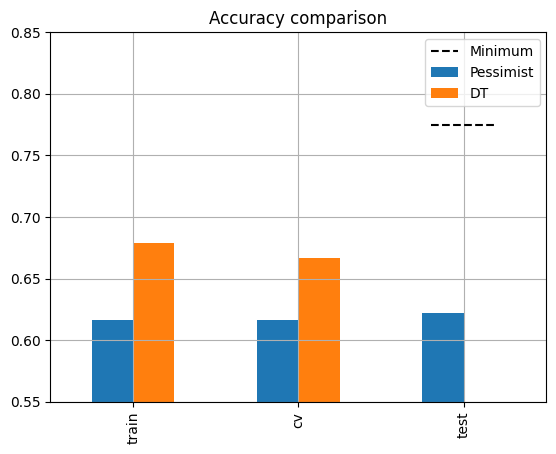

In [132]:
ax = scores[['train', 'cv', 'test']].T.plot.bar()
ax.grid()
x, dx = 2, .2
ax.hlines(y=0.775, xmin=x - dx, xmax=x + dx, linestyle='--', color='k')
ax.set_ylim([.55, 0.85])
ax.set_title('Accuracy comparison');
ax.legend(['Minimum', *scores.index],);# loc='lower right')

The data based model improved in cross validation and no extreme overfitting occurs on the train set. 

How will it perform on the test set? 

In [133]:
yh = model.predict(X_test[features])
yh = pd.Series(yh, X_test.index, name='Survived')
# save submission
yh.to_csv(data_path/'submission_test.csv') 

Ready to submit the predictions! Upload submission.